In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import PIL
import glob 
import os
from keras.preprocessing.image import (
    ImageDataGenerator,
    load_img,
    img_to_array,
    array_to_img
)

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input,decode_predictions
import skimage
from skimage import io
from skimage import transform


Using TensorFlow backend.


In [220]:
dataset = pd.read_csv("./Exercise1 - data.csv", header=None)

In [221]:
dataset.shape

(569, 32)

In [222]:
dataset.iloc[:,1].value_counts()

#the dataset is a little bit unbalanced 
#Bening instances = 63%
#Metastatic instances = 37%

B    357
M    212
Name: 1, dtype: int64

# Check if there are any null values

In [223]:
dataset.info()
# All Data are ok 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
0     569 non-null int64
1     569 non-null object
2     569 non-null float64
3     569 non-null float64
4     569 non-null float64
5     569 non-null float64
6     569 non-null float64
7     569 non-null float64
8     569 non-null float64
9     569 non-null float64
10    569 non-null float64
11    569 non-null float64
12    569 non-null float64
13    569 non-null float64
14    569 non-null float64
15    569 non-null float64
16    569 non-null float64
17    569 non-null float64
18    569 non-null float64
19    569 non-null float64
20    569 non-null float64
21    569 non-null float64
22    569 non-null float64
23    569 non-null float64
24    569 non-null float64
25    569 non-null float64
26    569 non-null float64
27    569 non-null float64
28    569 non-null float64
29    569 non-null float64
30    569 non-null float64
31    569 non-null float64
dtypes: float64(30), int64(1), obj

In [224]:
# we can drop the ID column because I dont think we will need it 
dataset = dataset.drop(dataset.columns[0], axis=1)

# Check if there is any type of correlation between features

In [225]:
#considering that the feature are split into three big groups (means,standard errors and largest values) 
#now we will consider just the group means and so the columns 3-12

mean_dataset = dataset.iloc[:,:11]
corr = mean_dataset.corr()
corr.style.background_gradient().set_precision(2)

,2,3,4,5,6,7,8,9,10,11
2,1,0.32,1,0.99,0.17,0.51,0.68,0.82,0.15,-0.31
3,0.32,1,0.33,0.32,-0.023,0.24,0.3,0.29,0.071,-0.076
4,1,0.33,1,0.99,0.21,0.56,0.72,0.85,0.18,-0.26
5,0.99,0.32,0.99,1,0.18,0.5,0.69,0.82,0.15,-0.28
6,0.17,-0.023,0.21,0.18,1,0.66,0.52,0.55,0.56,0.58
7,0.51,0.24,0.56,0.5,0.66,1,0.88,0.83,0.6,0.57
8,0.68,0.3,0.72,0.69,0.52,0.88,1,0.92,0.5,0.34
9,0.82,0.29,0.85,0.82,0.55,0.83,0.92,1,0.46,0.17
10,0.15,0.071,0.18,0.15,0.56,0.6,0.5,0.46,1,0.48
11,-0.31,-0.076,-0.26,-0.28,0.58,0.57,0.34,0.17,0.48,1


In [226]:
#between many variables there is a strong correlations, but to understand better
#we will plot a PairGrid that will tell us if there is also a correlation with the diagnosis

In [227]:
#rename the label column for semplicity
mean_dataset = mean_dataset.rename(columns={1:"diagnosis"})

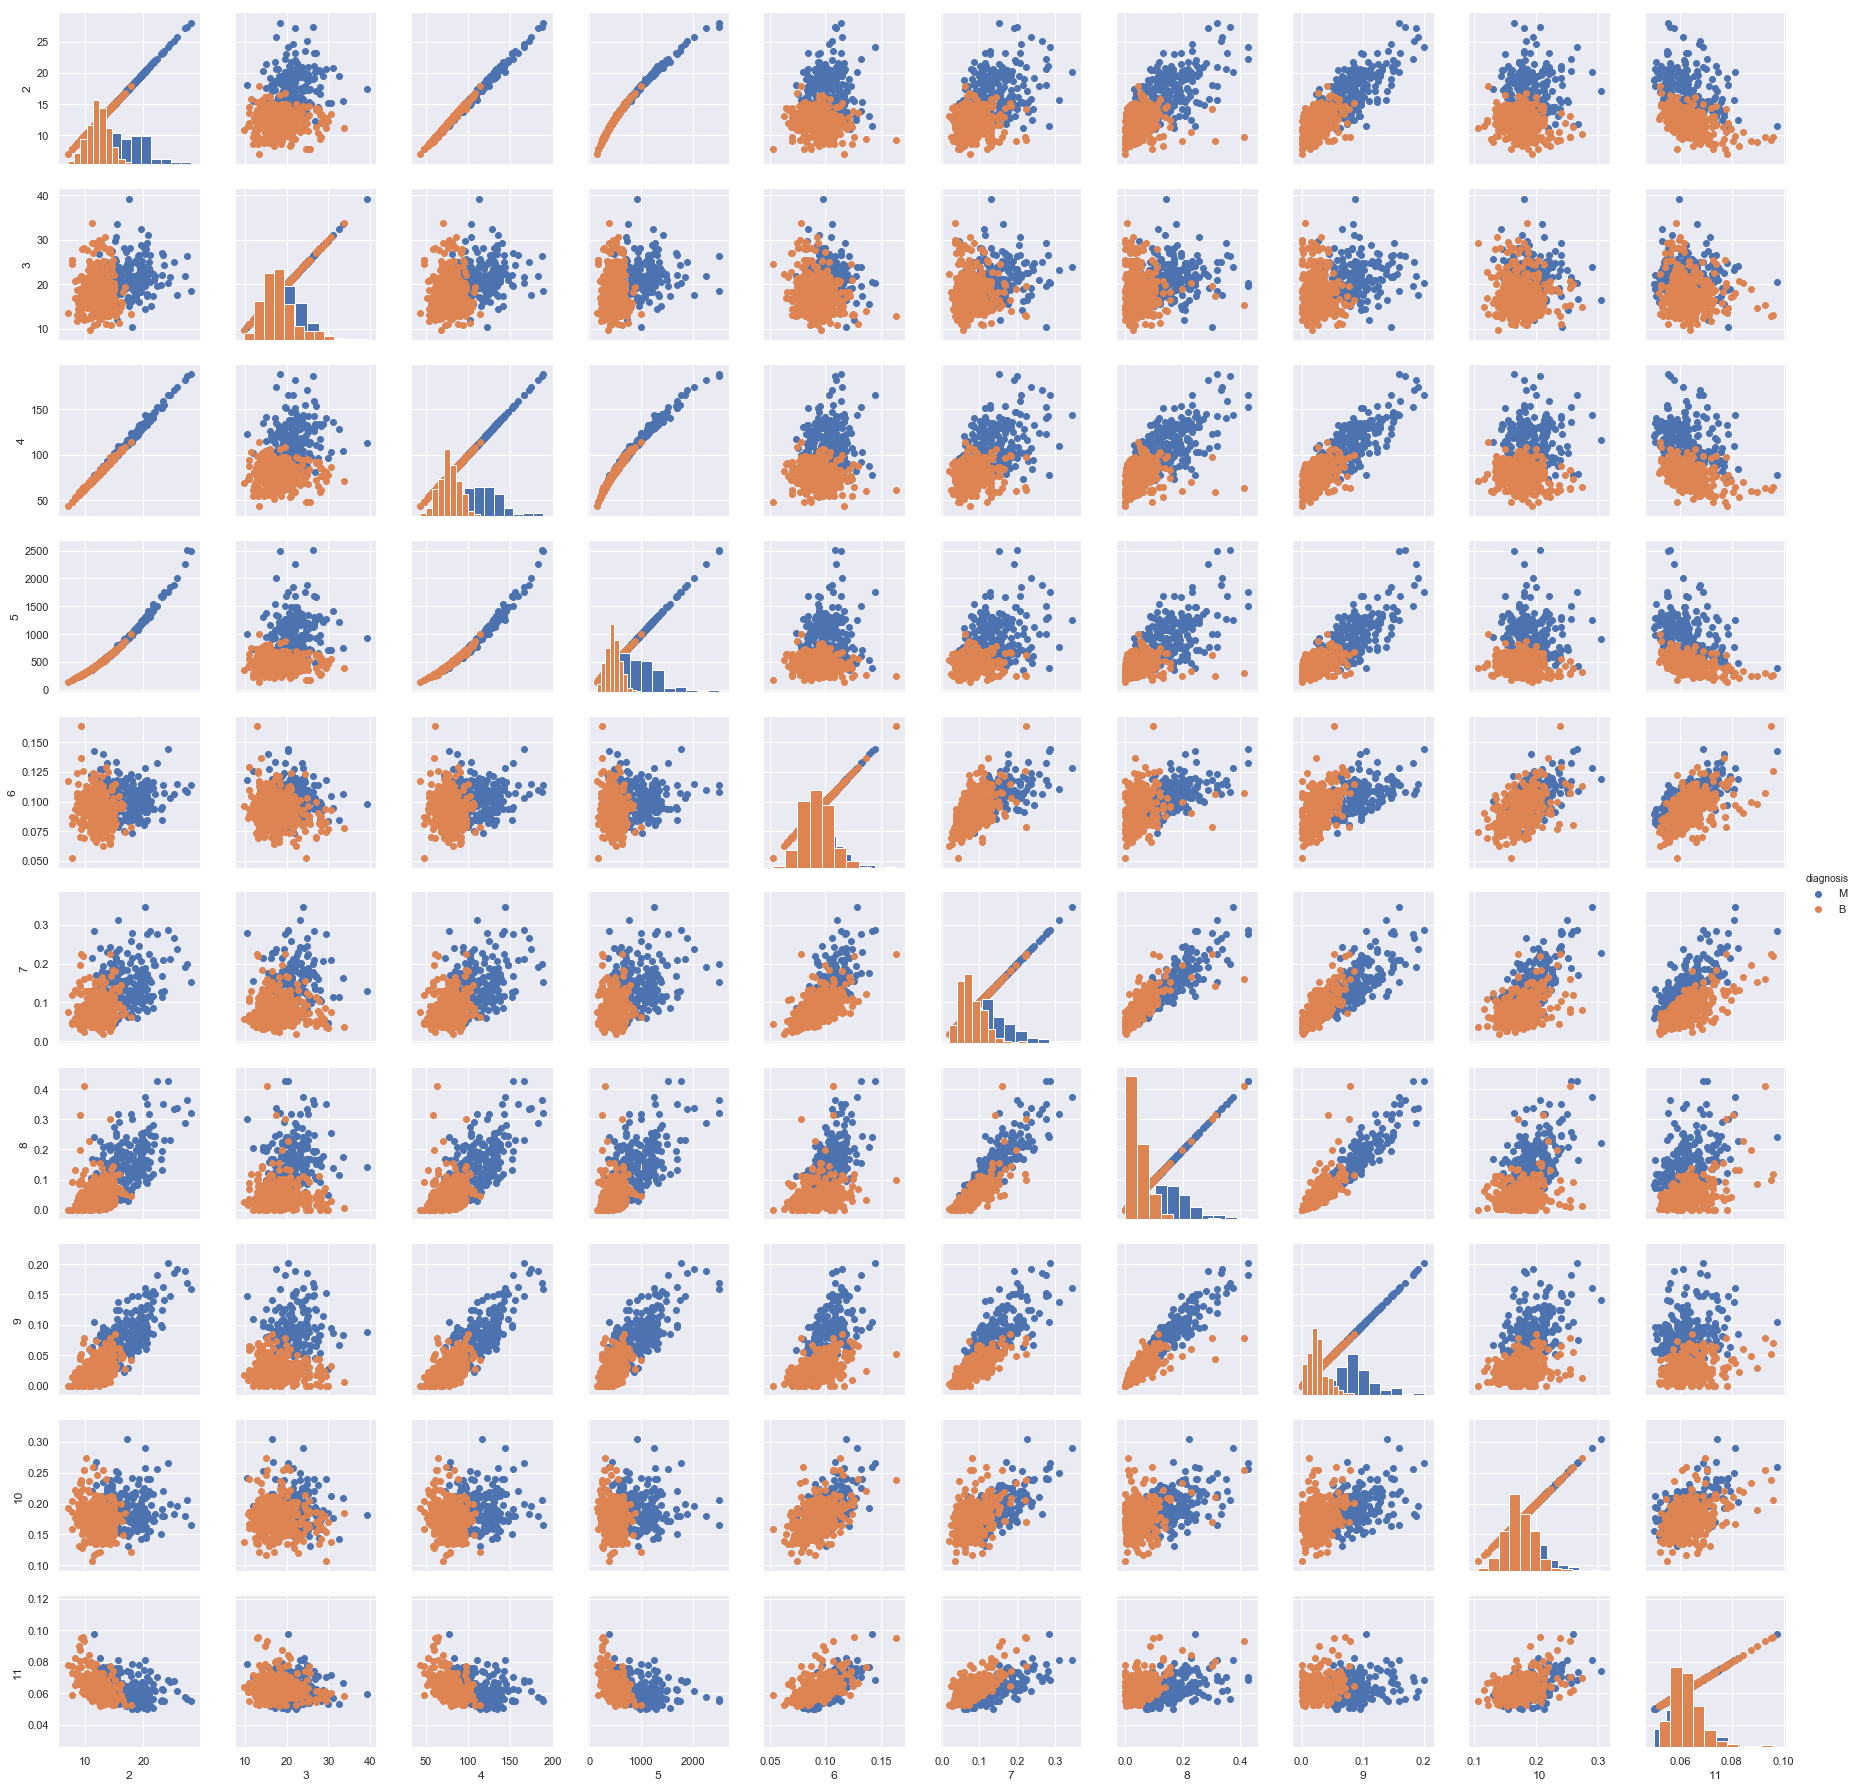

In [228]:
import matplotlib.pyplot as plt
import seaborn as sns; 
g = sns.PairGrid(mean_dataset,hue="diagnosis")
g = g.map_diag(plt.hist)
g = g.map(plt.scatter)
g = g.add_legend()


In [229]:
#How it is noticeable from this scatter plot, for the most variables (Mean values of cell radius, perimeter, area, compactness, 
#concavity and concave points) if there are large values the diagnosis is metastatic.
#It means that there is a correlation between the most those mean variables and the diagnosis.
#Furthermore it looks like variables have gaussian distribution

# Preprocessing Data

In [230]:
#Now we will prepare the data for the classification

In [231]:
#First of all Transform the label that is a categorical variable into a numerical form 

columns_label = pd.get_dummies(dataset[1])
dataset = dataset.drop(dataset.columns[0], axis=1)
dataset = pd.concat([dataset,columns_label], axis=1)


In [262]:
input_data = dataset.iloc[:,:30]

#in label I will keep just the column (M) becasue it is a binary classification 
label = dataset.iloc[:,31:]

In [263]:
#Considering that the variable are Gaussian we can use the standardization method 
# that standardize features by removing the mean and scaling to unit variance

scaler =StandardScaler()
input_standardize = scaler.fit_transform(input_data)

In [264]:
#I was thinking about applying some dimensionality reduction methos as PCA but considered the size of the dataset it may be not
#necessay 

# Prediction

In [259]:
#Considering the size of the dataset and that the the problem is a binary class one we decide to use SVM

In [265]:
#transform labels from pandas to numpy
label = label.values
label = label.ravel()


#The first thing to do is to split the dataset for training and test .
train_x, test_x, train_label, test_label = train_test_split(input_standardize, label, test_size=0.3)





In [267]:
#Train a SVM on training set

clf = svm.SVC(probability=True)
clf.fit(train_x, train_label)

classifier_score = clf.score(test_x, test_label)
print ('\nThe classifier test accuracy score is {:.3f}\n'.format(classifier_score))


The classifier accuracy score is 0.982



In [275]:
#Considering that it is not a time series another sophisticated way to calculate the accuracy 
#is the cross validation, where basically the test set is not constant but it will change at each iteration

result = cross_val_score(svm.SVC(), input_standardize, label)

print (result)

#These three values represent the test accuracy, and are three becasue by default the numper of paritition created is 3.
#It means that there will be three iteration where 2 folds, namely 66% of data, will be used for the training and the remaining
#one for the test.


[0.96315789 0.98421053 0.97354497]


In [277]:
max(result)

0.9842105263157894

In [280]:
avg,uncertainty = result.sum()/3, [max(result)-result.sum()/3,result.sum()/3-min(result)]
print("Average =  {:2f}, uncertainty = [+{:2f},-{:2f}]".format(avg,uncertainty[0],uncertainty[1]))

Average =  0.973638, uncertainty = [+0.010573,-0.010480]


# Tuning hyper-parameters of a model

In [282]:
#Tuning the hyper-parameters of a model is a fundamental partthat may help to improve the performance
#One easy way to do that in python is using GridSearch

svm.SVC().get_params()
#The most important parameter that can be tuned are:
#- C that represent the cost of misclassification
#- s the parameter of a Gaussian Kernel
#- kernel says the type of kernel used to classify the points, the rbf uses normal curves around the data points


{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [292]:
kernel_types = [ 'linear' ,  'poly' ,  'rbf' ,  'sigmoid' ]
C = [0.00001,0.0001,0.01,0.1,1,10]
gamma = [0.001, 0.01, 0.1, 1]
param_grid = {'C': C, 'gamma' : gamma, 'kernel':kernel_types}
grid_search = GridSearchCV(svm.SVC(), param_grid)
grid_search.fit(train_x, train_label)
print("Best parmas are : " , grid_search.best_params_)
print("Best score is : ", grid_search.best_score_)

Best parmas are :  {'gamma': 0.001, 'kernel': 'linear', 'C': 0.1}
Best score is :  0.9748743718592965


In [294]:
#Train a SVM on training set with best parmas

clf = svm.SVC(probability=True, C=0.1, gamma=0.001, kernel='linear')
clf.fit(train_x, train_label)

classifier_score = clf.score(test_x, test_label)
print ('\nThe classifier test accuracy score is {:.3f}\n'.format(classifier_score))


The classifier test accuracy score is 0.988



# Classification using raw images 

In [295]:
#The easiest way to do this is using some pre-trained model as ResNet but first of all I will try to build 
# a deep network from scratch just to demonstrate that I know what I am talking about 

In [54]:
#convert from GIF to jpg


files = glob.glob("./Raw_images/Training/Training_Malignant/*.gif") 
# print(files)
for imageFile in files:
    filepath,filename = os.path.split(imageFile)
    filterame,exts = os.path.splitext(filename)
    print ("Processing: " + imageFile,filterame)
    im = Image.open(imageFile)
    if im.mode in ['1', 'P']:
        im = im.convert('RGB')

    #increase number of image (augmentation)

    #rotate
    img_rotated_90 = im.rotate( angle=90)
    img_rotated_180 = im.rotate( angle=180)


    im.save( './Raw_images/Training/Train_Benign'+filterame+'.jpg','JPEG')
    img_rotated_90.save( './Raw_images/Training_good/Train_Benign/'+filterame+'_rotated_90.jpg','JPEG')
    img_rotated_180.save( './Raw_images/Training_good/Train_Malign/'+filterame+'_rotated_180.jpg','JPEG')

Processing: ./Raw_images/Training/Training_Malignant\91_6838.gif 91_6838
Processing: ./Raw_images/Training/Training_Malignant\91_9555.gif 91_9555
Processing: ./Raw_images/Training/Training_Malignant\92_6125.gif 92_6125
Processing: ./Raw_images/Training/Training_Malignant\92_6424.gif 92_6424
Processing: ./Raw_images/Training/Training_Malignant\92_6682.gif 92_6682
Processing: ./Raw_images/Training/Training_Malignant\92_6954.gif 92_6954
Processing: ./Raw_images/Training/Training_Malignant\92_7241.gif 92_7241


In [57]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [58]:
train_generator = ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_generator = ImageDataGenerator(rescale = 1./255)
training_set = train_generator.flow_from_directory('./Raw_images/Training_good',
target_size = (64, 64),
class_mode = 'binary')
test_set = test_generator.flow_from_directory('./Raw_images/Test_good',
target_size = (64, 64),
class_mode = 'binary')

Found 37 images belonging to 2 classes.
Found 5 images belonging to 2 classes.


In [64]:
# Initialising the CNN
classifier = Sequential()
# Step 1 - Convolution
classifier.add(Conv2D(64, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a second convolutional layer
classifier.add(Conv2D(32, (2, 2), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Step 3 - Flattening
classifier.add(Flatten())
# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))
# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.fit_generator(training_set,
steps_per_epoch = 37,
epochs = 2,
validation_data = test_set,
validation_steps = 5)

Epoch 1/2
37/37 [==============================] - 8s 206ms/step - loss: 0.4906 - acc: 0.7192 - val_loss: 0.6736 - val_acc: 0.6000
Epoch 2/2
37/37 [==============================] - 8s 203ms/step - loss: 0.2042 - acc: 0.9169 - val_loss: 0.6625 - val_acc: 0.8000


# Using ResNet

In [ ]:
model=ResNet50(include_top=True,weights='imagenet')

 36806656/102853048 [=========>....................] - ETA: 8:16

In [ ]:
def hack_resnet(input_size):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_size)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(num_classes, activation='sigmoid', name='fc1000')(x)
    
    # this is the model we will train
    newmodel = Model(inputs=base_model.input, outputs=x)

    return newmodel

model = hack_resnet(training_set.image_shape)

In [ ]:
mode.compile(loss='binary_crossentropy',optimizer = 'adam', metrics=['accuracy'])

# Final Consideration